# Uplimit Practice A/B Testing Course: Project 3

## Setup

Load data into Google Collab (skip this block if you are running the notebook elsewhere).

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1tiDlmytUHJYJGKB81xNewkq8Yg7PnnRO/view?usp=sharing
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1KAOmK_MJgtJxjjYyrNd-eWMQDT0Ai4yr/view?usp=sharing
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1KU-70QSYLGJJ6jJtlWHEpodzj4f9Fe31/view?usp=sharing
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/13tQIi6Sf12xzTV-qVYfwj6CyHwK0pFmy/view?usp=sharing

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?id=1tiDlmytUHJYJGKB81xNewkq8Yg7PnnRO
To: /content/dataset_landing_page.csv
100% 6.75M/6.75M [00:00<00:00, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KAOmK_MJgtJxjjYyrNd-eWMQDT0Ai4yr
To: /content/dataset_price_v2_early.csv
100% 1.99M/1.99M [00:00<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KU-70QSYLGJJ6jJtlWHEpodzj4f9Fe31
To: /content/dataset_price_v2.csv
100% 4.85M/4.85M [00:00<00:00, 79.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=13tQIi6Sf12xzTV-qVYfwj6CyHwK0pFmy
To: /content/df_price_1_early.csv
100% 2.14M/2.14M [00:00<00:00, 165MB/s]


Import libraries

In [2]:
# Lirbary basics
import numpy as np
import pandas as pd
import scipy.stats as stats # For pvalue
import math # For power calculation

Helper function to get the 95% confidence interval. Inputs:
* Mean treatment - average conversion rate of the treatment group
* Mean control - average conversion rate of the control group
* N treatment - number of samples in the treatment group
* N control - number of samples in the control group
* ci = The width of the confidence interval. 0.95 by default

You can read more about the math behind the confidence interval function [here](https://s3.amazonaws.com/assets.datacamp.com/production/course_6165/slides/chapter4.pdf).

In [3]:
def get_ci(mean_treatment, mean_control, n_treatment, n_control, ci = 0.95):
    sd = ((mean_treatment * (1 - mean_treatment)) / n_treatment + (mean_control * (1 - mean_control)) / n_control)**0.5
    lift = mean_treatment - mean_control
    val = stats.norm.isf((1 - ci) / 2)
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    return((lwr_bnd, upr_bnd))

Helper function to calcuate the results. It will compute and return the relative and absolute lift between variant and control, p-value, and lower and upper bound for the 95% confidence interval. A standard two-sided t-test with an assumption of equal variance is used to compute the p-value.

Inputs:
* DF = data frame with each row being a sample in the A/B test. It must have a column called "variant" that takes on the value "control" or "treatment
* Metric = the metric we want to evaluate. This must be 'new_active_listings','new_booked_listings', or 'cancellations'). If it is not one of these values an "invalid metric" error will be thrown.

In [4]:
def calculate_results(df,metric):
    # Check
    if metric not in ('new_active_listing','new_booked_listing','new_cancelled_listing','bookings_4w'):
        raise Exception("Invalid metric")

    # Values and relative difference
    mean_control = df.loc[df['variant'] == "control",metric].mean()
    mean_treatment = df.loc[df['variant'] == "treatment",metric].mean()

    abs_diff = mean_treatment-mean_control
    rel_diff = (mean_treatment-mean_control)/mean_control

    # P-Value -- two-sided ttest, assumes normal distribution
    data_group1 = list(df.query('variant == "control"')[metric])
    data_group2 = list(df.query('variant == "treatment"')[metric])

    results = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
    pvaue = results.pvalue

    # 95% confidence intervals
    [ci_low, ci_high] = get_ci(mean_treatment,mean_control,len(data_group2),len(data_group1),.95)
    ci_low = ci_low/mean_control
    ci_high = ci_high/mean_control

    return(rel_diff,abs_diff,results.pvalue,ci_low,ci_high)

In [5]:
import pandas as pd
import numpy as np
from scipy import stats

def custom_calculate_results(df, metric, dimensions=None):
    # Check if the metric is valid
    if metric not in ('new_active_listing', 'new_booked_listing', 'new_cancelled_listing'):
        raise Exception("Invalid metric")

    results = {'Dimension': [], 'Level': [], 'Relative Difference': [], 'Absolute Difference': [], 'P-Value': [], '95% CI Lower': [], '95% CI Upper': []}

    # Define a function to calculate the metrics
    def custom_calculate_metrics(df_subset):
        mean_control = df_subset.loc[df_subset['variant'] == "control", metric].mean()
        mean_treatment = df_subset.loc[df_subset['variant'] == "treatment", metric].mean()

        abs_diff = mean_treatment - mean_control
        rel_diff = (mean_treatment - mean_control) / mean_control

        # P-Value -- two-sided ttest, assumes normal distribution
        data_group1 = df_subset[df_subset['variant'] == "control"][metric]
        data_group2 = df_subset[df_subset['variant'] == "treatment"][metric]

        results = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
        pvalue = results.pvalue

        # 95% confidence intervals
        ci_low, ci_high = get_ci(mean_treatment, mean_control, len(data_group2), len(data_group1), 0.95)
        ci_low = ci_low / mean_control
        ci_high = ci_high / mean_control

        return rel_diff, abs_diff, pvalue, ci_low, ci_high

    # If no dimensions are given, calculate for the entire dataframe
    if not dimensions:
        results['Dimension'].append('Overall')
        results['Level'].append('')
        rel_diff, abs_diff, pvalue, ci_low, ci_high = custom_calculate_metrics(df)
        results['Relative Difference'].append(rel_diff)
        results['Absolute Difference'].append(abs_diff)
        results['P-Value'].append(pvalue)
        results['95% CI Lower'].append(ci_low)
        results['95% CI Upper'].append(ci_high)
    else:
        # Calculate for each dimension
        for dimension in dimensions:
            for level in df[dimension].unique():
                df_subset = df[df[dimension] == level]
                results['Dimension'].append(dimension)
                results['Level'].append(level)
                rel_diff, abs_diff, pvalue, ci_low, ci_high = custom_calculate_metrics(df_subset)
                results['Relative Difference'].append(rel_diff)
                results['Absolute Difference'].append(abs_diff)
                results['P-Value'].append(pvalue)
                results['95% CI Lower'].append(ci_low)
                results['95% CI Upper'].append(ci_high)

    # Convert the results to a Pandas DataFrame
    df_results = pd.DataFrame(results)

    return df_results


## Background

Welcome back **TinyTravelers**'s awesome product data scientist! You have developed strong relationships with PaM and the engineers on your team. You are a smooth, efficient, happy product-improving machine. Leadership has taken note and has given your team more resources to grow. You now have some new engineers and a new product manager, Maximus Impact ("Max" for short).

Like in past weeks, three A/B tests need to be designed and analyzed. Some back and forth communication with Max might also be needed.

## Task 1: Landing page change

The team has a hypothesis that a photo of a family instead of a baby will be more compelling to potential hosts. The thought of a baby staying alone in a house is terrifying. But a family with older kids and adults? Much less scary. That's the idea, anyways. So they want to try testing a photo for the landing page. See the design change below.

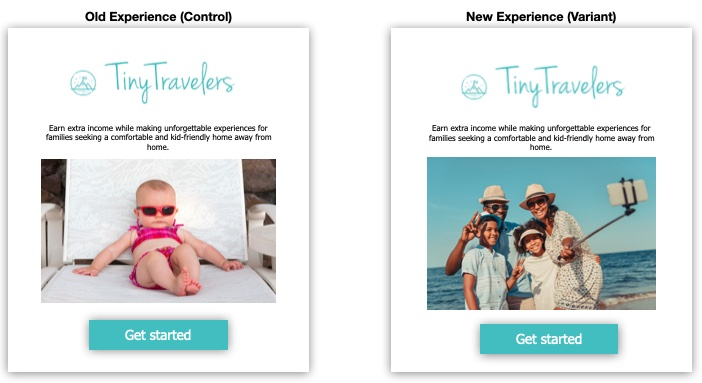

### Task 1.a. Test Design: How long should the test run and how will the launch/ no launch decision be made?

Like with prior weeks, we first want to design the test. The test should be triggered upon loading the landing page. The hypothesis is "If we show a picture of a family instead of a baby alone on the landing page it will increase conversion and therefore new booked listings because hosts will be less afraid to share their homes."

Now you need to determine how long the test should run and how will final ship vs no ship decision be made. You can assume there will be 6000 new users per day reaching the landing page, and the cohort-to-book rate is 20%. Max hopes to detect a 2% change if it’s there, but he also doesn't want the test to run for more than three weeks as it's blocking some other work the team hopes to do.

You can use an online sample size calculator (e.g., Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)). If you find that 2% is not feasible in 3 weeks, write how you would communicate the trade-off to Max.

Remember, we're building on what we learned last week, so don't be afraid to look over your Week 1 and 2 projects if it will help you!

## ANSWER 1.a

| Metric | Baseline Rate | Minimum Detectable Lift | Sample Size <br> Needed Per Variant | Days Needed <br> (6k daily)|
|-|-|-|-|-|
| New Booked Listings | 20% | 2% relative increase (to 20.4%) | 157,328 | 52|
| New Booked Listings | 20% | 3% relative increase (to 20.6%) | 70,001 | 24|
| New Booked Listings | 20% | 3.5% relative increase (to 20.7%) | 51,457 | 18|
| New Booked Listings | 20% | 4% relative increase (to 20.8%) | 39418 | 14|
| New Booked Listings | 20% | 5% relative increase (to 21%) | 25,255 |9|

Assumptions:
- 80% power
- 95% confidence

Unfortunately, the 6k daily traffic to this page will not be enough for us to detect the desired 2% impact in 3 weeks - we would need 8 weeks to detect this change which I think we both know is too long.

However, I present some viable alternatives we could either:
1. Run the test for 2 weeks and hope to detect a 4% relative increase.
2. Run the test for 3 weeks where the smallest possible change we can hope detect is around 3.5% given the time constraints.
3. Relax the time constrains by an extra week (4 weeks instead of 3 weeks) which would enable us to detect a 3% increase.

If all 3 of these alternatives are unworkable I can also reduce our confidence to 90% which increases our chances of detecting a false positive from 1/20 to 1/10.

Decision criteria:
- Launch if new booked listings increases by (INSERT_CHOSEN_MDE_HERE)% or more with statistical significance
- Do not launch otherwise

### Task 1.b. Test analysis

**Warning**: This may give away the answer to part a, so you should complete the run time analysis first.

You bring these MDE vs run-time points to Max to align on the run-time. After discussing the run time vs. detectable change with Max, you aligned on accepting a higher MDE and running the test for four weeks with an alpha of 0.10. That means you will launch the test if the point estimate for new booked listings is positive with a p-value is less than 0.10.

Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided.

In [6]:
df_landing = pd.read_csv('/content/dataset_landing_page.csv')

In [9]:
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_landing, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_booked_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,0.021563,0.001757,0.191059,-0.010761,0.053887


## Answer 1.b
- We have a non-statistically significant increase in NBL of 2%
- This does not meet our lauch criterion of a 4% increase in NBL with a p-value < 0.10
- My recommendation would hence be to not launch this feature

### Task 1.c. Stakeholder management

You share your recommendation in the stakeholder review meeting. Max speaks up:

"Looks to me like this change was actually solid, +2% on new booked listings! And the p-value is pretty close to 0.1, so I think we should ship."

How do you reply?

---
## Answer 1.c
You're right that in this instance of the experiment we indeed have a 2% increase in NBL. However, the data do not support this happening again with high confidence since a p-value of close to 0.20 implies that we have 20% chance of this result being false positive. Shipping this feature is hence a risky decision.

---

## Task 2: Recommended price

Given the success of the default title in week 1 (remember chatGPT &rarr; 📈 &rarr; 🍾?), the team came up with the idea to try a default price for homes as well. At a high level, to come up with the recommended price, the team uses information that the host has entered about the home so far (e.g., location, how many guests can fit, etc.) and data from the existing home to come up with a price they think this house would be booked at. The model predicts a price while the page is loaded to ensure it's ready to display to the host when they see the page.

See the UI change below.

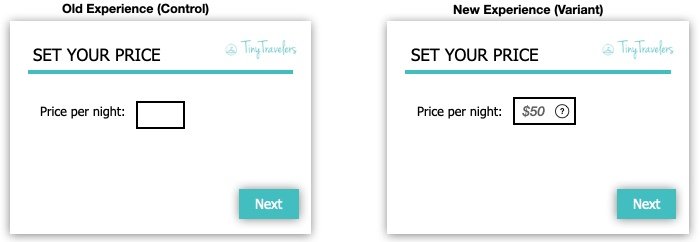

### Task 2.a. Test design by determining run time

This test should be triggered when a user clicks "next" on the previous page. The hypothesis is: "If we default the price to a recommended value, it will increase new booked listings because it will reduce friction in the onboarding flow, resulting in more listings."

You can assume that about 4K new users arrive on the price page of the onboarding flow each day. And the cohort-to-book rate is estimated to be 40% because the cohorting happens later in the flow when only the higher intent people are still there. You can use an online sample size calculator (e.g., Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)). Given that the default title had over a 10% relative increase  (week 1 project), Max is optimistic about this change. Still, he also recognizes this is a different kind of problem and later in the flow, so the impact might not be that big. So he'd like you to bring back some run-time vs. minimal detectable effect options.

Please share some run time vs MDE options. For an idea on what this could look like, refer to the [test design module](https://corise.com/course/practical-ab-testing/v2/module/test-design-basics#corise_clgpg1yqy000j3b712q0xi8wk), but instead of having one column be "users per a variant" it could be "needed run-time."


## ANSWER 2.a

| Metric | Baseline Rate | Minimum Detectable Lift | Sample Size <br> Needed Per Variant | Weeks Needed <br> (4k daily)|
|-|-|-|-|-|
| New Booked Listings | 40% | 1% relative increase (to 40.4%) | 235,582 | 17|
| New Booked Listings | 40% | 2% relative increase (to 40.8%) | 58,923 | 3|
| New Booked Listings | 40% | 3% relative increase (to 41.2%) | 26,200 | 2|
| New Booked Listings | 40% | 5% relative increase (to 42%) | 9440 | 1|

Assumptions:
- 80% power
- 95% confidence

Here I present the trade off between MDE and Weeks Needed to run the test.

Decision criteria:
- Launch if new booked listings increases by (INSERT_CHOSEN_MDE_HERE)% or more with statistical significance
- Do not launch otherwise

### Task 2.b. Stakeholder management

**Warning** this may reveal the answer to the previous task so please complete the run-time first!

After discussing the options with Max, you collectively decide that 28 days is a good balance. We like to stick with run-times in week increments so sacrificing the 29th day seems OK. The team put a lot of work into developing the algorithm so Max wants to position them to detect a 2.1% change.

The test starts off and everyone is feeling cautiously optimistic and excited for more champagne 🍾.

About 48 hours pass when Max shows up at your desk.

"SOMETHING IS WRONG! The results look really bad. I know we said this was going to run for 28 days, but I feel like something is up. Can you take a look?"

You oblige. The results below are the test results after running for 2 days. Please analyze the results and share your reply to Max.

_Basic_: Please analyze the results and share your recommendation of how to proceed.

_Bonus_: Explore the data carefully, and try to determine what went wrong. Is there any additional data would you ask for to help investigate what happened?

In [10]:
df_price_1_early = pd.read_csv('/content/df_price_1_early.csv')

In [11]:
df_price_1_early.head(10)

,id_user,variant,continent,booked_previously,device,new_active_listing,new_booked_listing,new_cancelled_listing,hrs_in_exp
0,7181,control,europe,0,android,1,0,0,16.604418
1,11229,treatment,north_america,0,android,1,0,0,30.393129
2,50786,treatment,europe,0,android,0,0,0,0.644750
3,9519,treatment,north_america,0,android,0,0,0,39.788688
4,20281,control,north_america,0,android,1,0,0,27.964404
5,7597,treatment,europe,0,android,0,0,0,45.181694
6,30559,control,australia,0,android,1,0,0,15.845216
7,22598,control,north_america,0,android,1,0,0,22.141170
8,48186,control,europe,1,android,1,0,0,30.271225
9,45681,treatment,north_america,0,android,0,0,0,1.387535


### Let's check first for assignment imbalance

In [12]:
from scipy.stats import chi2_contingency

def ab_test_chi2(data_column):
    """
    Performs a Chi-squared test on A/B testing data where the groups are labeled 'control' and 'treatment'.

    :param data_column: Pandas Series with two possible values ('control' and 'treatment').
    :return: The p-value from the Chi-squared test.
    """

    if not isinstance(data_column, pd.Series):
        raise ValueError("The data_column must be a Pandas Series.")

    # Mapping 'control' to 0 and 'treatment' to 1
    data_column_mapped = data_column.map({'control': 0, 'treatment': 1})

    if data_column_mapped.isnull().any():
        raise ValueError("The data_column must contain only 'control' and 'treatment' values.")

    # Count the occurrences of control (0) and treatment (1)
    observed_counts = data_column_mapped.value_counts()

    # Assuming a 50/50 split for the expected counts
    total_count = observed_counts.sum()
    expected_counts = pd.Series([total_count / 2, total_count / 2], index=observed_counts.index)

    # Perform the Chi-squared test
    chi2, p_value, _, _ = chi2_contingency([observed_counts, expected_counts])

    return p_value, total_count, observed_counts


### eh, it's close-ish, but I'd say no assignment imbalance here

In [14]:
p_value, total_count, observed_counts = ab_test_chi2(df_price_1_early['variant'])
print(f"Total Count: {total_count}")
print(f"Observed Count:\n{observed_counts}")
print(f"Chi-squared test p-value: {p_value}")

Total Count: 36803
Observed Count:
1    18582
0    18221
Name: variant, dtype: int64
Chi-squared test p-value: 0.18575107774426286


Let's now have a look at NBL split

In [17]:
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_price_1_early, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_booked_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,-0.243167,-0.011464,3.327342e-08,-0.329547,-0.156786


Let's now have a look at NBL split by some key dimensions

In [18]:
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
custom_calculate_results(df_price_1_early, metric, dimensions=["continent", "booked_previously", "device"])

Analysis of new_booked_listing


,Dimension,Level,Relative Difference,Absolute Difference,P-Value,95% CI Lower,95% CI Upper
0,continent,europe,-0.239163,-0.010188,7.358436e-03,-0.414179,-0.064146
1,continent,north_america,-0.250051,-0.012327,8.436090e-05,-0.374769,-0.125333
2,continent,australia,-0.299050,-0.016793,1.103490e-01,-0.664843,0.066742
3,continent,south_america,-0.199765,-0.008800,1.953863e-01,-0.503104,0.103574
4,continent,africa,-0.321506,-0.016284,1.772476e-02,-0.587714,-0.055297
5,continent,asia,0.001724,0.000073,9.941322e-01,-0.457384,0.460832
6,booked_previously,0,-0.225672,-0.010662,4.733943e-06,-0.322422,-0.128921
7,booked_previously,1,-0.315375,-0.014734,1.237615e-03,-0.506933,-0.123817
8,device,android,-0.448044,-0.020810,2.877262e-15,-0.559479,-0.336609
9,device,web,0.035319,0.001642,8.136208e-01,-0.258179,0.328817



We have an extremely stat-sig negative movement in NBL for users on Android whilst Web and iOS users have a non-stat-sig negligible movement in this same metric. This would lead me to believe we have a significant bug in the Android implementation of this A/B test and that we should roll this test back and try again.

## Task 3: Recommended price v2

**Warning** this may reveal part of the solution to task 2, so please complete that first!

The bug you identified in the initial price recommendation test has been resolved. The team wants to try again. The design you did in task 2 holds, and you and Max decide that 28 days is still a good run-time.

### Task 3.a. Stakeholder management

The 48 hour mark passes and the results look OK. Everyone gives a collective sigh of relief. But then after 3 days, Max shows up to your desk.

These results are SO GOOD. We should ship right now. You ask for a tapering of excitement while you look into the results.

Below we provide the results after 3 days of the test running. Please analyze the results and make a recommendation on how to proceed.

In [23]:
df_price_2_early = pd.read_csv('/content/dataset_price_v2_early.csv')
df_price_2_early.head(10)

,id_user,variant,new_active_listing,new_booked_listing,new_cancelled_listing,hrs_to_cohort
0,94392,treatment,0,0,0,14.051205
1,52714,control,1,0,0,31.296125
2,6114,control,1,0,0,8.946806
3,89046,treatment,1,0,0,2.026259
4,62358,control,0,0,0,37.539148
5,4936,control,0,0,0,0.000435
6,31863,control,0,0,0,42.447373
7,98175,treatment,0,0,0,1.575159
8,69614,control,0,0,0,46.155131
9,85414,treatment,1,0,0,8.854560


### As always, we check for assignment imbalance

In [20]:
p_value, total_count, observed_counts = ab_test_chi2(df_price_2_early['variant'])
print(f"Total Count: {total_count}")
print(f"Observed Count:\n{observed_counts}")
print(f"Chi-squared test p-value: {p_value}")

Total Count: 50636
Observed Count:
0    25360
1    25276
Name: variant, dtype: int64
Chi-squared test p-value: 0.7966591048184714


In [63]:
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_price_2_early, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_booked_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,0.142018,0.005712,0.001547,0.054088,0.229948


### He's right, they do look good but maybe we have a novelty effect, let's check that

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_novelty_effect(df, metric):
    # Create new cohort column which essentially turns hrs_to_cohort
    # into an integer and re-indexes
    max_hours = int(df['hrs_to_cohort'].max())
    df['cohort'] = df['hrs_to_cohort'] + 1
    df['cohort'] = df['cohort'].astype('int')
    results = []

    for cohort in range(1, max_hours + 1):
        # For each hour grab the cohort of users who have been exposed to the experiment
        # for that long or greater
        cohort_df = df[df['cohort'] >= cohort]

        # Compute the difference in the target metric between treatment and control
        treatment_mean = cohort_df[cohort_df['variant'] == 'treatment'][metric].mean()
        control_mean = cohort_df[cohort_df['variant'] == 'control'][metric].mean()
        metric_difference_percentage = ((treatment_mean - control_mean) / control_mean) * 100

        # Store results in ordered list
        results.append((cohort, metric_difference_percentage))

    results_df = pd.DataFrame(results, columns=['hrs_in_experiment', 'relative_increase'])

    # Plot the results
    plt.figure(figsize=(8, 4))
    sns.set(style="whitegrid", context="notebook", font_scale=0.8)
    sns.lineplot(x='hrs_in_experiment', y='relative_increase', data=results_df, marker='o')
    plt.ylabel("Relative NBL Increase (%)")
    plt.xlabel("Hours in Experiment")
    plt.xticks(rotation=45)
    sns.despine()

    plt.show()


### Looks like there could be a novelty effect

<ipython-input-102-d77b930932a1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  metric_difference_percentage = ((treatment_mean - control_mean) / control_mean) * 100
<ipython-input-102-d77b930932a1>:21: RuntimeWarning: invalid value encountered in double_scalars
  metric_difference_percentage = ((treatment_mean - control_mean) / control_mean) * 100


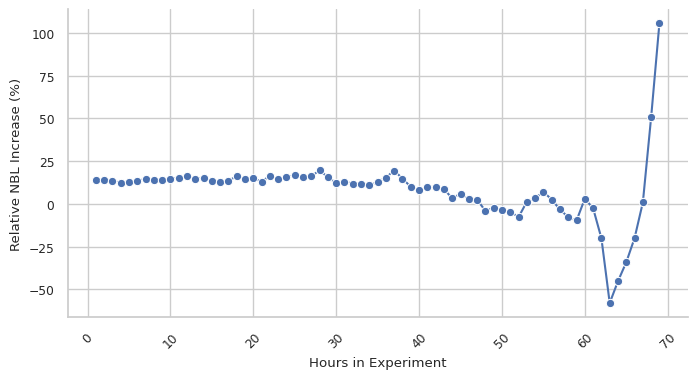

In [103]:
analyze_novelty_effect(df_price_2_early, 'new_booked_listing')

## Summary
- Overall, the results from the first 3 days of the test look extremely positive. There are no signs of assignment imbalance, dilution or bugs.
- However, there does seem to be a novelty effect where users who have beem exposed for greater than 48 hours are showing little to no movement on the metric
- We should wait to see how this feature pans out for the full 4 weeks (28 days)

### Task 3.b. Test analysis

**Warning** this may give away the answer to task 3.a. so we recommend doing that first.

Max agrees to wait the full 28 days, though he can't help but ask about how the test is doing a few more times :) The four weeks are up and it's time to look at the results. Please analyze the data provided below, and share a summary and recommendation on how to proceed.

In [64]:
df_price_2 = pd.read_csv('/content/dataset_price_v2.csv')

In [66]:
df_price_2.head(10)

,id_user,variant,new_active_listing,new_booked_listing,new_cancelled_listing,hrs_to_cohort,cohort_day
0,94392,treatment,0,0,0,14.051205,1.0
1,52714,control,1,0,0,31.296125,1.0
2,6114,control,1,1,0,8.946806,0.0
3,89046,treatment,1,1,0,2.026259,0.0
4,62358,control,0,0,0,37.539148,2.0
5,4936,control,0,0,0,0.000435,0.0
6,31863,control,0,0,0,42.447373,2.0
7,98175,treatment,0,0,0,1.575159,0.0
8,69614,control,0,0,0,46.155131,2.0
9,85414,treatment,1,0,0,8.854560,0.0


In [68]:
p_value, total_count, observed_counts = ab_test_chi2(df_price_2['variant'])
print(f"Total Count: {total_count}")
print(f"Observed Count:\n{observed_counts}")
print(f"Chi-squared test p-value: {p_value}")

Total Count: 111287
Observed Count:
0    55853
1    55434
Name: variant, dtype: int64
Chi-squared test p-value: 0.37675407015459506


In [65]:
metric = 'new_booked_listing'
print(f"Analysis of {metric}")
pd.DataFrame(calculate_results(df_price_2, metric),
             index=['rel diff','abs diff','pvalue','ci low','ci high']).T

Analysis of new_booked_listing


,rel diff,abs diff,pvalue,ci low,ci high
0,0.066392,0.012642,1.127813e-07,0.041862,0.090922


## Summary
- Extremely stat-sig 6.6% relative increase in NBL due to this new feature
- Ship it

### Task 3.c._(BONUS)_ Deep dive in analysis

Although everyone is happy the results ended positive in the end and the price recommender was able to launch, you want to understand _why_ the early results were so positive.

#### Task 3.c.i. What hypotheses do you have for why the early results were so positive?

Why do you think the early results were so much more positive than the end results? What analysis could you do to confirm or reject those hypthesis?

No code here- just thoughts.

- We only received the high intent users in the early days of the experiment
- More chilled, browsing type users began to appear as we let the experiment run it's course

#### Task 3.c.ii. Show the results over time

Do the results vary by the day someone was cohorted? What does this tell you?

This section can take a while and require more advanced Python than you've needed to-date for this course, so we recommend coming back to it after the other tasks are complete.

In [70]:
df_price_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111287 entries, 0 to 111286
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_user                111287 non-null  int64  
 1   variant                111287 non-null  object 
 2   new_active_listing     111287 non-null  int64  
 3   new_booked_listing     111287 non-null  int64  
 4   new_cancelled_listing  111287 non-null  int64  
 5   hrs_to_cohort          111287 non-null  float64
 6   cohort_day             111287 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 5.9+ MB


In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_novelty_effect_days(df, metric):
    # Create new cohort column which essentially turns hrs_to_cohort
    # into an integer and re-indexes
    max_day = int(df['cohort_day'].max())
    df['cohort'] = df['cohort_day'] + 1

    results = []

    for cohort in range(1, max_day + 1):
        # For each day, grab the cohort of users who have been exposed to the experiment
        # for that long or greater
        cohort_df = df[df['cohort'] >= cohort]

        # Compute the difference in the target metric between treatment and control
        treatment_mean = cohort_df[cohort_df['variant'] == 'treatment'][metric].mean()
        control_mean = cohort_df[cohort_df['variant'] == 'control'][metric].mean()
        metric_difference_percentage = ((treatment_mean - control_mean) / control_mean) * 100

        # Store results in ordered list
        results.append((cohort, metric_difference_percentage))

    results_df = pd.DataFrame(results, columns=['cohort_day', 'relative_increase'])

    # Plot the results
    plt.figure(figsize=(8, 4))
    sns.set(style="whitegrid", context="notebook", font_scale=0.8)
    sns.lineplot(x='cohort_day', y='relative_increase', data=results_df, marker='o')
    plt.ylabel("Relative NBL Increase (%)")
    plt.xlabel("Days in Experiment")
    plt.xticks(rotation=45)
    sns.despine()

    plt.show()


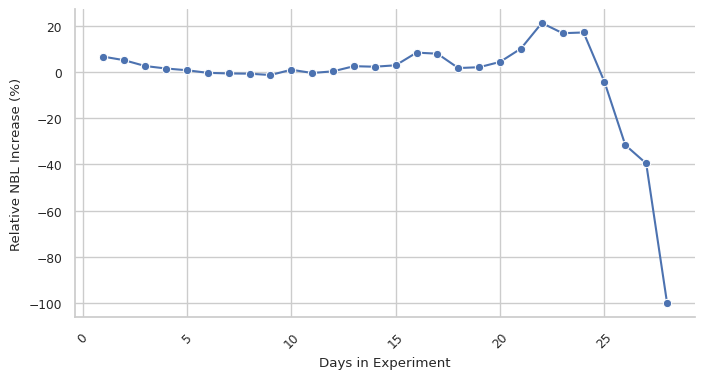

In [86]:
analyze_novelty_effect_days(df_price_2, 'new_booked_listing')

In [104]:
df_price_2

,id_user,variant,new_active_listing,new_booked_listing,new_cancelled_listing,hrs_to_cohort,cohort_day,cohort
0,94392,treatment,0,0,0,14.051205,1.0,2.0
1,52714,control,1,0,0,31.296125,1.0,2.0
2,6114,control,1,1,0,8.946806,0.0,1.0
3,89046,treatment,1,1,0,2.026259,0.0,1.0
4,62358,control,0,0,0,37.539148,2.0,3.0
...,...,...,...,...,...,...,...,...
111282,67380,control,1,0,0,124.015565,5.0,6.0
111283,13908,treatment,0,0,0,136.513029,6.0,7.0
111284,110661,treatment,0,0,0,116.307261,5.0,6.0
111285,17635,treatment,0,0,0,189.437331,8.0,9.0
